# Predicting the Baseball Hall of Fame

In [1]:
# Initial imports
import pandas as pd
import numpy as np
from path import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
pip install psycopg2

In [4]:
pip install config

Note: you may need to restart the kernel to use updated packages.


In [15]:

# This gist contains a direct connection to a local PostgreSQL database
# called "suppliers" where the username and password parameters are "postgres"

# This code is adapted from the tutorial hosted below:
# http://www.postgresqltutorial.com/postgresql-python/connect/

import psycopg2

# Establish a connection to the database by creating a cursor object
# The PostgreSQL server must be accessed through the PostgreSQL APP or Terminal Shell

# conn = psycopg2.connect("dbname=suppliers port=5432 user=postgres password=postgres")

# Or:
conn = psycopg2.connect(host="localhost", port = 5432, database="baseballdatabank", user="postgres", password="j021591asd")

# Create a cursor object
cur = conn.cursor()

cur.execute("""SELECT * FROM public."People" limit 10;""")
query_results = cur.fetchall()

# Extract the column names
col_names = []
for elt in cur.description:
    col_names.append(elt[0])
df_people = pd.DataFrame(query_results, columns=col_names)
# print(query_results)

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

In [16]:
df_people

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981,12,27,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215,75,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934,2,5,USA,AL,Mobile,2021.0,1.0,22.0,...,Aaron,Henry Louis,180,72,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939,8,5,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190,75,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954,9,8,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190,75,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972,8,25,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184,73,L,L,2001-09-10,2006-04-13,abada001,abadan01
5,abadfe01,1985,12,17,D.R.,La Romana,La Romana,NaN,NaN,NaN,...,Abad,Fernando Antonio,235,74,L,L,2010-07-28,2021-10-01,abadf001,abadfe01
6,abadijo01,1850,11,4,USA,PA,Philadelphia,1905.0,5.0,17.0,...,Abadie,John W.,192,72,R,R,1875-04-26,1875-06-10,abadj101,abadijo01
7,abbated01,1877,4,15,USA,PA,Latrobe,1957.0,1.0,6.0,...,Abbaticchio,Edward James,170,71,R,R,1897-09-04,1910-09-15,abbae101,abbated01
8,abbeybe01,1869,11,11,USA,VT,Essex,1962.0,6.0,11.0,...,Abbey,Bert Wood,175,71,R,R,1892-06-14,1896-09-23,abbeb101,abbeybe01
9,abbeych01,1866,10,14,USA,NE,Falls City,1926.0,4.0,27.0,...,Abbey,Charles S.,169,68,L,L,1893-08-16,1897-08-19,abbec101,abbeych01


In [3]:
# get names of all files in source folder
from os import listdir
from os.path import isfile, join

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
files

['AllstarFull.csv',
 'AwardsPlayers.csv',
 'Batting.csv',
 'BattingPost.csv',
 'Fielding.csv',
 'FieldingPost.csv',
 'HallOfFame.csv',
 'People.csv',
 'Pitching.csv',
 'PitchingPost.csv']

In [5]:
# add every file to a DataFrame
df_allstarfull = pd.read_csv(mypath+files[0])
df_awardsplayers = pd.read_csv(mypath+files[1])
df_batting = pd.read_csv(mypath+files[2])
df_battingpost = pd.read_csv(mypath+files[3])
df_fielding = pd.read_csv(mypath+files[4])
df_fieldingpost = pd.read_csv(mypath+files[5])
df_halloffame = pd.read_csv(mypath+files[6])
df_people = pd.read_csv(mypath+files[7])
df_pitching = pd.read_csv(mypath+files[8])
df_pitchingpost = pd.read_csv(mypath+files[9])

In [6]:
# explore hallf of fame table
df_halloffame.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


In [7]:
df_halloffame.describe()

,yearID,ballots,needed,votes
count,4191.000000,3994.000000,3837.000000,3994.000000
mean,1969.712956,322.574862,245.397707,51.934402
std,23.555073,125.265128,94.325990,86.137219
min,1936.000000,78.000000,59.000000,0.000000
25%,1950.000000,226.000000,175.000000,2.000000
50%,1966.000000,274.000000,213.000000,10.000000
75%,1989.000000,427.000000,323.000000,65.000000
max,2018.000000,581.000000,436.000000,555.000000


In [8]:
df_halloffame.shape

(4191, 9)

In [9]:
# indcuted vs not inducted
inducted_breakdown = df_halloffame.groupby('inducted').count()['playerID'].values
inducted_breakdown

array([3868,  323], dtype=int64)

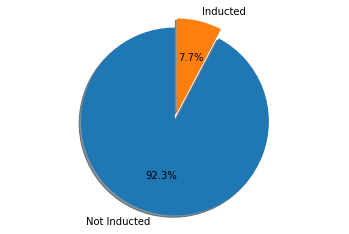

In [10]:
# pie chart for inducted - not inducted 
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Not Inducted', 'Inducted'
sizes = inducted_breakdown
explode = (0, 0.1)  # only "explode" the "Inducted" players

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
df_halloffame[df_halloffame.inducted == 'Y']

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN
...,...,...,...,...,...,...,...,...,...
4157,guerrvl01,2018,BBWAA,422.0,317.0,392.0,Y,Player,NaN
4158,thomeji01,2018,BBWAA,422.0,317.0,379.0,Y,Player,NaN
4159,hoffmtr01,2018,BBWAA,422.0,317.0,337.0,Y,Player,NaN
4189,morrija02,2018,Veterans,NaN,NaN,NaN,Y,Player,NaN


In [12]:
# inducted by category
df_halloffame[df_halloffame.inducted == 'Y'].groupby(['category']).count()['playerID']

category
Manager               23
Pioneer/Executive     34
Player               256
Umpire                10
Name: playerID, dtype: int64

In [13]:
df_halloffame[df_halloffame.inducted == 'Y'].groupby(['category']).count().index

Index(['Manager', 'Pioneer/Executive', 'Player', 'Umpire'], dtype='object', name='category')

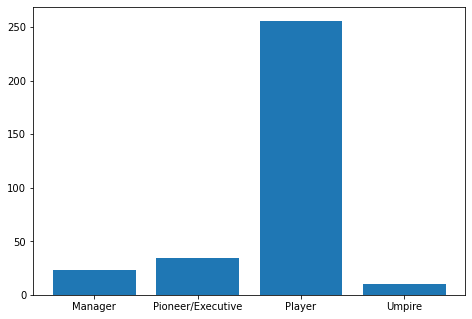

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = df_halloffame[df_halloffame.inducted == 'Y'].groupby(['category']).count().index
categories_count = df_halloffame[df_halloffame.inducted == 'Y'].groupby(['category']).count()['playerID']
ax.bar(categories,categories_count)
plt.show()

In [15]:
df_halloffame_players = df_halloffame[df_halloffame.category == 'Player']
df_halloffame_players.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN


In [16]:
# indcuted vs not inducted for players
inducted_breakdown_players = df_halloffame_players.groupby('inducted').count()['playerID'].values
inducted_breakdown_players

array([3810,  256], dtype=int64)

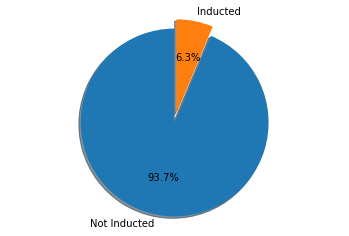

In [17]:
# pie chart for inducted - not inducted 
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Not Inducted', 'Inducted'
sizes = inducted_breakdown_players
explode = (0, 0.1)  # only "explode" the "Inducted" players

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [18]:
# explore people table
df_people.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,22.0,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [19]:
df_people.describe()

,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
count,20259.000000,20091.000000,19950.000000,10004.000000,10003.000000,10002.000000,19554.000000,19634.000000
mean,1935.220396,6.630481,15.617243,1967.059976,6.480456,15.522296,187.961594,72.357594
std,43.008946,3.464092,8.762114,33.353873,3.537484,8.790894,22.429934,2.616806
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000
25%,1897.000000,4.000000,8.000000,1944.000000,3.000000,8.000000,172.000000,71.000000
50%,1943.000000,7.000000,16.000000,1969.000000,6.000000,15.000000,185.000000,72.000000
75%,1974.000000,10.000000,23.000000,1994.000000,10.000000,23.000000,200.000000,74.000000
max,2001.000000,12.000000,31.000000,2022.000000,12.000000,31.000000,320.000000,83.000000


In [20]:
df_people.shape

(20370, 24)

In [21]:
df_people.dtypes

playerID         object
birthYear       float64
birthMonth      float64
birthDay        float64
birthCountry     object
birthState       object
birthCity        object
deathYear       float64
deathMonth      float64
deathDay        float64
deathCountry     object
deathState       object
deathCity        object
nameFirst        object
nameLast         object
nameGiven        object
weight          float64
height          float64
bats             object
throws           object
debut            object
finalGame        object
retroID          object
bbrefID          object
dtype: object

In [22]:
df_halloffame_players.groupby('playerID').count()

,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
playerID,,,,,,,,
aaronha01,1,1,1,1,1,1,1,0
abbotji01,1,1,1,1,1,1,1,0
adamsba01,15,15,15,14,15,15,15,1
adamsbo03,1,1,1,1,1,1,1,0
adamssp01,2,2,2,2,2,2,2,0
...,...,...,...,...,...,...,...,...
zahnge01,1,1,1,1,1,1,1,0
zambrca01,1,1,1,1,1,1,1,0
zeileto01,1,1,1,1,1,1,1,0


In [23]:
# explore batting table
df_batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [24]:
print(df_batting.columns.tolist())

['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']


In [25]:
df_batting_rbi = df_batting.groupby(['playerID']).sum()['RBI'].sort_values(ascending=False)

In [26]:
df_batting_rbi = pd.DataFrame(df_batting_rbi).reset_index()

In [27]:
df_batting_rbi.head()

,playerID,RBI
0,aaronha01,2297.0
1,ruthba01,2217.0
2,pujolal01,2150.0
3,rodrial01,2086.0
4,ansonca01,2075.0


In [28]:
df_batting_rbi.dtypes

playerID     object
RBI         float64
dtype: object

In [29]:
df_batting_rbi.shape

(20166, 2)

In [30]:
df_batting_rbi = df_batting_rbi.join(df_people.set_index('playerID'), on='playerID', how='left')
df_batting_rbi

,playerID,RBI,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aaronha01,2297.0,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
1,ruthba01,2217.0,1895.0,2.0,6.0,USA,MD,Baltimore,1948.0,8.0,...,Ruth,George Herman,215.0,74.0,L,L,1914-07-11,1935-05-30,ruthb101,ruthba01
2,pujolal01,2150.0,1980.0,1.0,16.0,D.R.,Distrito Nacional,Santo Domingo,NaN,NaN,...,Pujols,Jose Alberto,235.0,75.0,R,R,2001-04-02,2021-10-03,pujoa001,pujolal01
3,rodrial01,2086.0,1975.0,7.0,27.0,USA,NY,New York,NaN,NaN,...,Rodriguez,Alexander Enmanuel,230.0,75.0,R,R,1994-07-08,2016-08-12,rodra001,rodrial01
4,ansonca01,2075.0,1852.0,4.0,17.0,USA,IA,Marshalltown,1922.0,4.0,...,Anson,Adrian Constantine,227.0,72.0,R,R,1871-05-06,1897-10-03,ansoc101,ansonca01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20161,krugge01,0.0,1955.0,2.0,12.0,USA,KS,Garden City,NaN,NaN,...,Krug,Gary Eugene,225.0,76.0,L,L,1981-04-29,1981-05-14,krugg101,krugge01
20162,krummal01,0.0,1865.0,1.0,13.0,USA,PA,Pittsburgh,1937.0,6.0,...,Krumm,Albert,145.0,NaN,NaN,R,1889-05-17,1889-05-17,kruma101,krummal01
20163,kubenje01,0.0,1974.0,8.0,24.0,USA,TX,Weimar,NaN,NaN,...,Kubenka,Jeffrey Scot,191.0,74.0,R,L,1998-09-06,1999-08-08,kubej001,kubenje01
20164,kubinti01,0.0,1972.0,1.0,20.0,USA,WA,Pullman,NaN,NaN,...,Kubinski,Timothy Mark,205.0,76.0,L,L,1997-07-16,1999-10-02,kubit001,kubinti01


In [31]:
df_batting_rbi.columns

Index(['playerID', 'RBI', 'birthYear', 'birthMonth', 'birthDay',
       'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth',
       'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst',
       'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut',
       'finalGame', 'retroID', 'bbrefID'],
      dtype='object')

In [32]:
df_batting_rbi = df_batting_rbi[['playerID', 'nameFirst', 'nameLast', 'RBI']]
df_batting_rbi_25 = df_batting_rbi.sort_values('RBI', ascending=False).head(25)
df_batting_rbi_25

,playerID,nameFirst,nameLast,RBI
0,aaronha01,Hank,Aaron,2297.0
1,ruthba01,Babe,Ruth,2217.0
2,pujolal01,Albert,Pujols,2150.0
3,rodrial01,Alex,Rodriguez,2086.0
4,ansonca01,Cap,Anson,2075.0
5,bondsba01,Barry,Bonds,1996.0
6,gehrilo01,Lou,Gehrig,1995.0
7,musiast01,Stan,Musial,1951.0
8,cobbty01,Ty,Cobb,1944.0
9,foxxji01,Jimmie,Foxx,1922.0


In [33]:
df_batting_rbi_25['fullName'] = df_batting_rbi_25[['nameFirst', 'nameLast']].apply(lambda x: ' '.join(x), axis=1)
df_batting_rbi_25 = df_batting_rbi_25.drop(columns=(['playerID', 'nameFirst', 'nameLast']))
df_batting_rbi_25

,RBI,fullName
0,2297.0,Hank Aaron
1,2217.0,Babe Ruth
2,2150.0,Albert Pujols
3,2086.0,Alex Rodriguez
4,2075.0,Cap Anson
5,1996.0,Barry Bonds
6,1995.0,Lou Gehrig
7,1951.0,Stan Musial
8,1944.0,Ty Cobb
9,1922.0,Jimmie Foxx


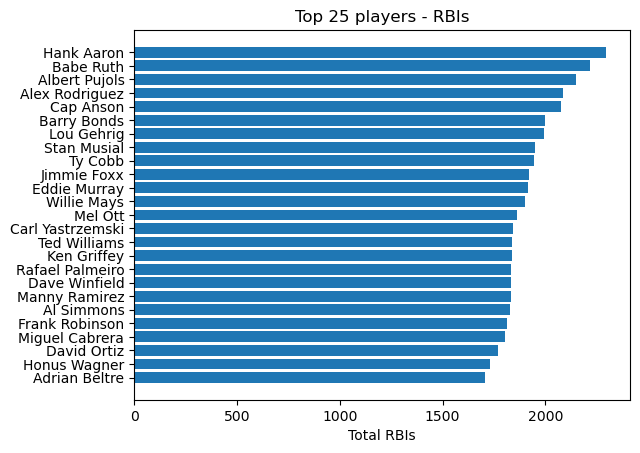

In [46]:
df_batting_rbi_25 = df_batting_rbi_25.sort_values(by=['RBI'])
player = df_batting_rbi_25['fullName']
rbi = df_batting_rbi_25['RBI']
y_pos = np.arange(len(player))

plt.barh(y_pos, rbi)
plt.title('Top 25 players - RBI''s')
plt.yticks(y_pos, player)
# plt.ylabel('Player Name')
plt.xlabel('Total RBI''s')
plt.show()